In [1]:
import os
from pytorch_lightning import Trainer
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
# import torchvision.models.resnet
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger



In [2]:
def create_model():
    model = torchvision.models.resnet34()
    model_weight_path = "../input/weights/resnet34.pth"
    assert os.path.exists(model_weight_path), "file {} does not exist.".format(model_weight_path)
    model.load_state_dict(torch.load(model_weight_path))
    # change fc layer structure
    in_channel = model.fc.in_features
    model.fc = nn.Linear(in_channel, 5)
    model.maxpool = nn.Identity()
    return model
print(create_model())

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): Identity()
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), p

In [3]:
class LitResnet(pl.LightningModule):

    def __init__(self, lr=0.05):
        super().__init__()

        self.save_hyperparameters()
        self.model = create_model()

    def forward(self, x):
        out = self.model(x)
        return F.log_softmax(out, dim=1)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        return loss


    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        return {'val_loss': loss}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        return {'val_loss': avg_loss}

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

In [4]:
from torchvision import datasets, transforms
# 对花朵数据集进行预处理
data_transform = {
        "train": transforms.Compose([transforms.RandomResizedCrop(224),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
        "val": transforms.Compose([transforms.Resize(256),
                                   transforms.CenterCrop(224),
                                   transforms.ToTensor(),
                                   transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    }

#     data_root = os.path.abspath(os.path.join(os.getcwd(), "../../.."))  # 父级工作目录
image_path = "../input/flower-date/flower_data"  # 将目录拼接起来
assert os.path.exists(image_path), "{} path does not exist.".format(image_path)
    # 制造训练集和验证集
train_dataset = datasets.ImageFolder(root=os.path.join(image_path, "train"), transform=data_transform["train"])
validate_dataset = datasets.ImageFolder(root=os.path.join(image_path, "val"),
                                            transform=data_transform["val"])
train_loader = DataLoader(train_dataset, batch_size=150, shuffle=True, num_workers=4)
validate_loader = DataLoader(validate_dataset, batch_size=150, shuffle=True, num_workers=4)

In [5]:
import os
model = LitResnet(lr=0.05)
trainer = Trainer(
    progress_bar_refresh_rate=20,
    max_epochs=5,
    gpus=1,
    logger=TensorBoardLogger('lightning_logs/', name='resnet'),
#     callbacks=[LearningRateMonitor(logging_interval='step')],
)

trainer.fit(model,train_loader,validate_loader)
trainer.save_checkpoint("example.ckpt")

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:349: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for val/test/predict dataloaders.
  f'Your {mode}_dataloader has `shuffle=True`, it is best practice to turn'


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [6]:
%reload_ext tensorboard
!kill 1098
%tensorboard --logdir lightning_logs/

/bin/bash: line 0: kill: (1098) - No such process


In [7]:
model = LitResnet.load_from_checkpoint(checkpoint_path="example.ckpt")
print(model)

LitResnet(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): Identity()
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (con

class: dandelion   prob: 1.000


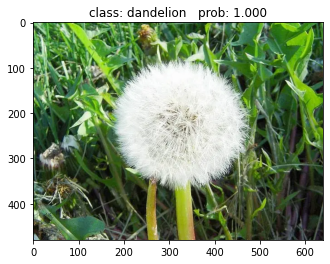

In [8]:
import os
import json
import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt


def main():
#     device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    data_transform = transforms.Compose(
        [transforms.Resize(256),
         transforms.CenterCrop(224),
         transforms.ToTensor(),
         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    # load image
    img_path = "../input/dandelions/dandelion.jpg"
    assert os.path.exists(img_path), "file: '{}' dose not exist.".format(img_path)
    img = Image.open(img_path)

    plt.imshow(img)
    # [N, C, H, W]
    img = data_transform(img)
    # expand batch dimension
    img = torch.unsqueeze(img, dim=0)

    # read class_indict
    json_path = '../input/typejson/class_indices.json'
    assert os.path.exists(json_path), "file: '{}' dose not exist.".format(json_path)

    json_file = open(json_path, "r")
    class_indict = json.load(json_file)

    # create model
#     model = resnet34(num_classes=5).to(device)

    # load model weights
#     weights_path = "../input/resnet/resNet-PS.pth"
#     model.load_state_dict(torch.load(weights_path))
    model = LitResnet.load_from_checkpoint(checkpoint_path="example.ckpt")
#     print(model)

    model.eval()
    with torch.no_grad():
        # predict class
        output = torch.squeeze(model(img)[0]).cpu()
        predict = torch.softmax(output, dim=0)
        predict_cla = torch.argmax(predict).numpy()

    print_res = "class: {}   prob: {:.3f}".format(class_indict[str(predict_cla)],
                                                  predict[predict_cla].numpy())
    plt.title(print_res)
    print(print_res)
    plt.show()


if __name__ == '__main__':
    main()


In [ ]:
# Start tensorboard.
%reload_ext tensorboard
!kill 821
%tensorboard --logdir lightning_logs/